## Model Data:

### Using a combination of governance characteristics and organizational characteristics (revenue, assets, ect.) I will predict the salary of Directors & Trustees.

In [265]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import plotly.express as px
# plt.style.use('bmh')
import warnings
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=[SettingWithCopyWarning, FutureWarning])


from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn import linear_model

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import jenkspy


from sklearn.preprocessing import power_transform

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

In [26]:
# import time start_time = time.time() model() end_time = time.time()

# time_taken = end_time - start_time

## IMPORT DATA

In [229]:
# import modeling dataset
df = pd.read_csv('02.data/model_dataset.csv')

In [230]:
df.head()

,reportable_comp,subsection,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_categories,total_ex_comp_per_company,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,EXEC_COMP_PERCENT_TOTAL_COMP
0,198085.0,501(c)(6),ME,1995,734264,650527.0,1608376.0,1638630.0,56277,"Public, Societal Benefit",198085,79,79,10,0,1052040,0,False,False,7,0.188287
1,87550.0,501(c)(6),ME,1911,173021,89089.0,632341.0,603122.0,56277,"Public, Societal Benefit",87550,20,20,8,100,397835,0,True,True,10,0.220066
2,64575.0,501(c)(3),ME,1896,2283338,49470.0,846299.0,941058.0,56277,"Arts, Culture, and Humanities",64575,17,17,6,50,215850,0,True,True,8,0.299166
3,62180.0,501(c)(6),ME,1927,17316,0.0,208615.0,183721.0,56277,"Public, Societal Benefit",62180,19,19,3,4,129714,0,True,True,9,0.479362
4,130513.0,501(c)(6),ME,1952,831930,314175.0,1021331.0,1143753.0,56277,"Public, Societal Benefit",130513,31,31,9,145,539848,0,True,True,12,0.241759


In [231]:
# identify natural breaks using jenks
breaks = jenkspy.jenks_breaks(df.reportable_comp, nb_class=30)

In [232]:
# keep all breaks less than 1M
# while including all breaks greater than 1M together
bins = [b for b in breaks if b < 1000000 or b == max(breaks)]

In [259]:
len(bins)

16

In [260]:
bins

[43510.0,
 82280.0,
 107853.0,
 136183.0,
 166570.0,
 198671.0,
 235415.0,
 278595.0,
 328514.0,
 385560.0,
 451729.0,
 528809.0,
 621230.0,
 731942.0,
 858984.0,
 21629920.0]

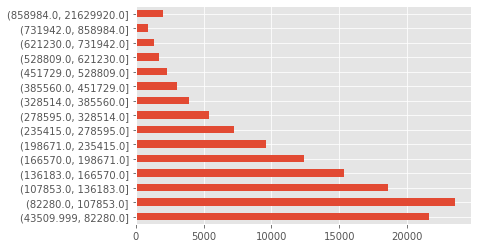

In [234]:
# examine the distribution 
# based on the number of people who fall into each bin
pd.cut(df.reportable_comp,
        bins=bins,
        include_lowest=True).value_counts().sort_index().plot(kind='barh')

In [337]:
# assign X and y variables
y = pd.cut(df.reportable_comp,
        bins=bins,
        include_lowest=True).cat.codes

X = pd.get_dummies(df.drop(['reportable_comp',
                            'subsection',
                            'state',
#                             'fundraiseservfee_expense_tot_curyr',
                           'EXEC_COMP_PERCENT_TOTAL_COMP'
#                            'formation_yr'
                           ], axis=1))

In [263]:
X

,assets,liabilities,expenses,revenue,state_median_income,total_ex_comp_per_company,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,salaries_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,"ntee_categories_Arts, Culture, and Humanities",ntee_categories_Education,ntee_categories_Environment and Animals,ntee_categories_Health,ntee_categories_Human Services,"ntee_categories_International, Foreign Affairs",ntee_categories_Mutual/Membership Benefit,"ntee_categories_Public, Societal Benefit",ntee_categories_Religion Related,"ntee_categories_Unknown, Unclassified"
0,734264,650527.0,1608376.0,1638630.0,56277,198085,79,79,10,0,1052040,False,False,7,0,0,0,0,0,0,0,1,0,0
1,173021,89089.0,632341.0,603122.0,56277,87550,20,20,8,100,397835,True,True,10,0,0,0,0,0,0,0,1,0,0
2,2283338,49470.0,846299.0,941058.0,56277,64575,17,17,6,50,215850,True,True,8,1,0,0,0,0,0,0,0,0,0
3,17316,0.0,208615.0,183721.0,56277,62180,19,19,3,4,129714,True,True,9,0,0,0,0,0,0,0,1,0,0
4,831930,314175.0,1021331.0,1143753.0,56277,130513,31,31,9,145,539848,True,True,12,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128770,30706549,1415457.0,14900828.0,14374374.0,77765,172346,20,20,314,555,9759364,True,True,11,0,0,0,0,1,0,0,0,0,0
128771,6169984,289803.0,1379284.0,1588525.0,77765,103660,17,17,37,100,607205,True,True,7,1,0,0,0,0,0,0,0,0,0
128772,28099317,1572837.0,8832969.0,9384856.0,77765,193873,9,9,245,20,5092952,True,True,10,0,0,0,0,1,0,0,0,0,0
128773,28099317,1572837.0,8832969.0,9384856.0,77765,193873,9,9,245,20,5092952,True,True,10,0,0,0,0,1,0,0,0,0,0


## Random Forest Classifier

In [252]:
df[df.EXEC_COMP_PERCENT_TOTAL_COMP == np.inf].shape

(691, 21)

In [258]:
rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X, y, cv=5)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



array([0.40113345, 0.38632658, 0.39879635, 0.36522853, 0.40890908])

In [256]:
rfr = rfc.fit(X, y)
f_importances = pd.DataFrame(rfc.feature_importances_,
                            X.columns,
                            columns=['importance']).sort_values('importance', ascending=False)
f_importances.head(30)*100

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



,importance
total_ex_comp_per_company,33.096361
expenses,7.523181
salaries_expense_tot_curyr,7.260440
liabilities,6.148823
assets,5.999054
revenue,5.896953
employee_tot_ct,5.304159
state_median_income,5.023037
formation_yr,4.739077
voting_indepmemb_ct,3.853772


### Examine feature correlations and consolidate features using PCA

(22.5, -0.5)

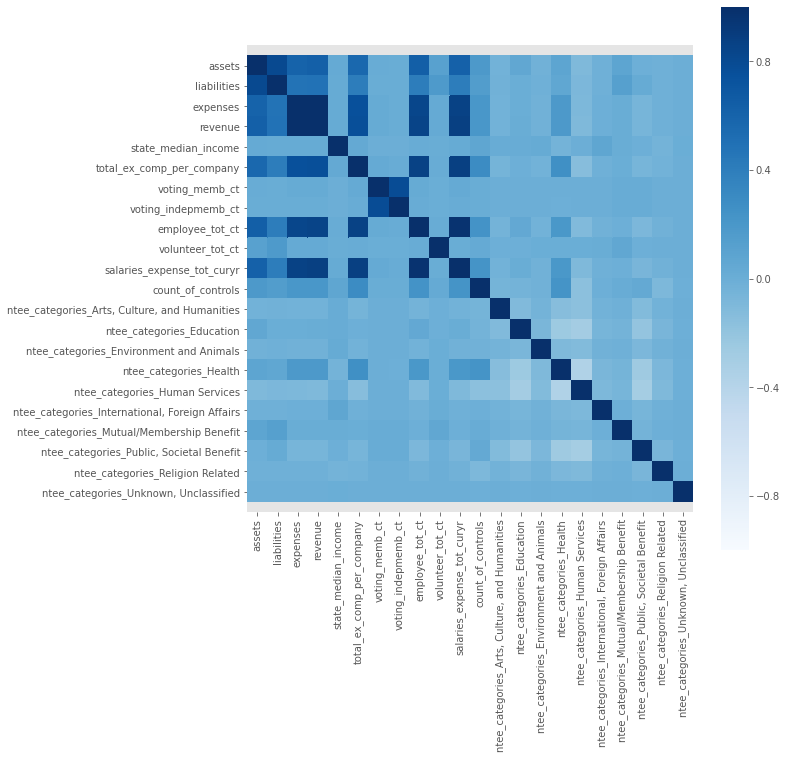

In [264]:
# compare features using a heatmap
plt.figure(figsize=(10, 10))

ax = sns.heatmap(X.select_dtypes(include=[np.number]).corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, annot=False, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [338]:
# based on visual inspection above
# identify features to be combined
X.corr().loc[:,'assets'].sort_values(ascending=False)

# .index[:7]

assets                                            1.000000
liabilities                                       0.812245
employee_tot_ct                                   0.633770
revenue                                           0.627096
salaries_expense_tot_curyr                        0.621949
expenses                                          0.606469
total_ex_comp_per_company                         0.563701
count_of_controls                                 0.181378
volunteer_tot_ct                                  0.115349
fundraiseservfee_expense_tot_curyr                0.095841
officer_comp_review                               0.085591
ntee_categories_Health                            0.084994
ntee_categories_Mutual/Membership Benefit         0.080555
ntee_categories_Education                         0.061463
ceo_comp_review                                   0.058579
state_median_income                               0.038198
voting_memb_ct                                    0.0196

In [288]:
X_std = pd.DataFrame(data = X_std, 
             columns = ['assets', 
                      'liabilities', 
                      'employee_tot_ct', 
                      'revenue',
                       'salaries_expense_tot_curyr', 
                      'expenses', 
                      'total_ex_comp_per_company'])

In [283]:
sklearn_pca = PCA(n_components=2)

sklearn_pca.fit_transform(X[['assets', 
                              'liabilities', 
                              'employee_tot_ct', 
                              'revenue',
                               'salaries_expense_tot_curyr', 
                              'expenses', 
                              'total_ex_comp_per_company']])

sklearn_pca.explained_variance_ratio_

array([0.80917697, 0.13871895])

In [339]:
# create the top 2 pca features
pd.DataFrame(data = sklearn_pca.fit_transform(df[['assets', 
                              'liabilities', 
                              'employee_tot_ct', 
                              'revenue',
                               'salaries_expense_tot_curyr', 
                              'expenses', 
                              'total_ex_comp_per_company']]), 
             columns = ['pca_1', 
                      'pca_2'])

,pca_1,pca_2
0,-4.430878e+08,-5.617256e+07
1,-4.444209e+08,-5.719780e+07
2,-4.425815e+08,-5.753576e+07
3,-4.448554e+08,-5.769666e+07
4,-4.435102e+08,-5.686888e+07
...,...,...
128770,-4.099853e+08,-4.788900e+07
128771,-4.389432e+08,-5.800993e+07
128772,-4.157236e+08,-5.489561e+07
128773,-4.157236e+08,-5.489561e+07


In [310]:
df.head()

,reportable_comp,subsection,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_categories,total_ex_comp_per_company,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,EXEC_COMP_PERCENT_TOTAL_COMP
0,198085.0,501(c)(6),ME,1995,734264,650527.0,1608376.0,1638630.0,56277,"Public, Societal Benefit",198085,79,79,10,0,1052040,0,False,False,7,0.188287
1,87550.0,501(c)(6),ME,1911,173021,89089.0,632341.0,603122.0,56277,"Public, Societal Benefit",87550,20,20,8,100,397835,0,True,True,10,0.220066
2,64575.0,501(c)(3),ME,1896,2283338,49470.0,846299.0,941058.0,56277,"Arts, Culture, and Humanities",64575,17,17,6,50,215850,0,True,True,8,0.299166
3,62180.0,501(c)(6),ME,1927,17316,0.0,208615.0,183721.0,56277,"Public, Societal Benefit",62180,19,19,3,4,129714,0,True,True,9,0.479362
4,130513.0,501(c)(6),ME,1952,831930,314175.0,1021331.0,1143753.0,56277,"Public, Societal Benefit",130513,31,31,9,145,539848,0,True,True,12,0.241759


In [313]:
df[['ntee_categories',
  'ceo_comp_review',
   'officer_comp_review']]

,ntee_categories,ceo_comp_review,officer_comp_review
0,"Public, Societal Benefit",False,False
1,"Public, Societal Benefit",True,True
2,"Arts, Culture, and Humanities",True,True
3,"Public, Societal Benefit",True,True
4,"Public, Societal Benefit",True,True
...,...,...,...
128770,Human Services,True,True
128771,"Arts, Culture, and Humanities",True,True
128772,Human Services,True,True
128773,Human Services,True,True


In [479]:
StandardScaler().fit_transform(df[['assets', 
  'liabilities', 
  'employee_tot_ct', 
  'revenue',
   'salaries_expense_tot_curyr', 
  'expenses', 
  'total_ex_comp_per_company']])

array([[-0.16421119, -0.13059908, -0.21137281, ..., -0.17218656,
        -0.16267329, -0.27887856],
       [-0.16447816, -0.13107003, -0.21178589, ..., -0.17388983,
        -0.16369047, -0.30049016],
       [-0.16347431, -0.13110326, -0.21219897, ..., -0.17436364,
        -0.1634675 , -0.30498219],
       ...,
       [-0.15119399, -0.12982542, -0.16283609, ..., -0.16166576,
        -0.15514417, -0.27970208],
       [-0.15119399, -0.12982542, -0.16283609, ..., -0.16166576,
        -0.15514417, -0.27970208],
       [-0.15959317, -0.13109943, -0.21075319, ..., -0.17174795,
        -0.16214782, -0.30039963]])

In [480]:
pca_vis = pd.concat([
    pd.DataFrame(data = sklearn_pca.fit_transform(StandardScaler().fit_transform(df[['assets', 
  'liabilities', 
  'employee_tot_ct', 
  'revenue',
   'salaries_expense_tot_curyr', 
  'expenses', 
  'total_ex_comp_per_company']])), 
             columns = ['pca_1', 
                      'pca_2']),
    df[['ntee_categories',
  'ceo_comp_review',
   'officer_comp_review']]
    
], axis=1)

In [481]:
pca_vis

,pca_1,pca_2,ntee_categories,ceo_comp_review,officer_comp_review
0,-0.488186,0.007955,"Public, Societal Benefit",False,False
1,-0.498369,0.012722,"Public, Societal Benefit",True,True
2,-0.499889,0.014285,"Arts, Culture, and Humanities",True,True
3,-0.501368,0.014166,"Public, Societal Benefit",True,True
4,-0.494380,0.011024,"Public, Societal Benefit",True,True
...,...,...,...,...,...
128770,-0.439432,-0.005733,Human Services,True,True
128771,-0.492775,0.012028,"Arts, Culture, and Humanities",True,True
128772,-0.453603,0.000400,Human Services,True,True
128773,-0.453603,0.000400,Human Services,True,True


In [482]:
pca_vis['pca_1'].max()

58.525615040245434

In [475]:
# for key, group in pca_vis.groupby('ntee_categories'):
#     print(key)

In [404]:
# list(pca_vis.ntee_categories.value_counts().index)

In [371]:
['red', 
 'blue', 
 'green', 
 'black', 
 'yellow', 
 'yellow', 
 'yellow', 
 'yellow', 
 'yellow', 
 'yellow']

['red', 'blue', 'green', 'black', 'yellow']

In [487]:
colors = dict(zip(list(pca_vis.ntee_categories.value_counts().index),
   ['red', 
 'blue', 
 'green', 
 'black', 
 'yellow', 
 'yellow', 
 'yellow', 
 'yellow', 
 'yellow', 
 'yellow']))

In [488]:
colors

{'Human Services': 'red',
 'Health': 'blue',
 'Public, Societal Benefit': 'green',
 'Education': 'black',
 'Arts, Culture, and Humanities': 'yellow',
 'Environment and Animals': 'yellow',
 'Religion Related': 'yellow',
 'International, Foreign Affairs': 'yellow',
 'Mutual/Membership Benefit': 'yellow',
 'Unknown, Unclassified': 'yellow'}

(-2.0, 2.0)

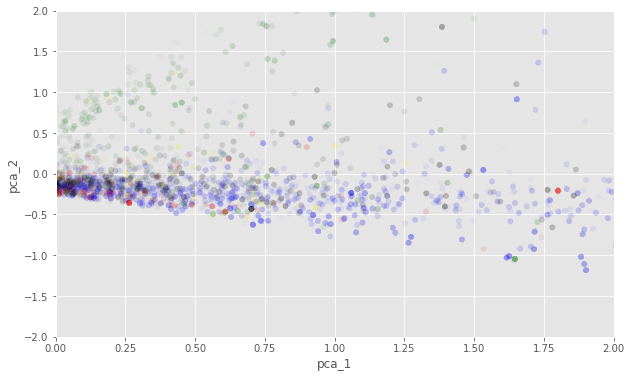

In [486]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(x='pca_1', 
                y='pca_2', 
                hue='ntee_categories', 
                data=pca_vis, 
                palette=colors,
               legend=False,
               edgecolor='none',
               alpha=.01)

plt.xlim(0, 2)
plt.ylim(-2, 2)

In [403]:
# plt.figure(figsize=(10, 10))
# grouped = pca_vis.groupby('ntee_categories')
# for key, group in grouped:
# #     ax.set_xlim(0, .2)
# #     ax.set_ylim(-2, 2)
#     ax = plt.scatter(group.plot(kind='scatter', x='pca_1', y='pca_2', c=colors[key], legend=False)

In [435]:
pca_vis

,pca_1,pca_2,ntee_categories,ceo_comp_review,officer_comp_review
0,-4.430878e+08,-5.617256e+07,"Public, Societal Benefit",False,False
1,-4.444209e+08,-5.719780e+07,"Public, Societal Benefit",True,True
2,-4.425815e+08,-5.753576e+07,"Arts, Culture, and Humanities",True,True
3,-4.448554e+08,-5.769666e+07,"Public, Societal Benefit",True,True
4,-4.435102e+08,-5.686888e+07,"Public, Societal Benefit",True,True
...,...,...,...,...,...
128770,-4.099853e+08,-4.788900e+07,Human Services,True,True
128771,-4.389432e+08,-5.800993e+07,"Arts, Culture, and Humanities",True,True
128772,-4.157236e+08,-5.489561e+07,Human Services,True,True
128773,-4.157236e+08,-5.489561e+07,Human Services,True,True


In [297]:
# list comprehension to find columns
# that were not consolidated with PCA
X[[i for i in list(X.columns) if i not in ['assets', 
                      'liabilities', 
                      'employee_tot_ct', 
                      'revenue',
                       'salaries_expense_tot_curyr', 
                      'expenses', 
                      'total_ex_comp_per_company']]]

,state_median_income,voting_memb_ct,voting_indepmemb_ct,volunteer_tot_ct,ceo_comp_review,officer_comp_review,count_of_controls,"ntee_categories_Arts, Culture, and Humanities",ntee_categories_Education,ntee_categories_Environment and Animals,ntee_categories_Health,ntee_categories_Human Services,"ntee_categories_International, Foreign Affairs",ntee_categories_Mutual/Membership Benefit,"ntee_categories_Public, Societal Benefit",ntee_categories_Religion Related,"ntee_categories_Unknown, Unclassified"
0,56277,79,79,0,False,False,7,0,0,0,0,0,0,0,1,0,0
1,56277,20,20,100,True,True,10,0,0,0,0,0,0,0,1,0,0
2,56277,17,17,50,True,True,8,1,0,0,0,0,0,0,0,0,0
3,56277,19,19,4,True,True,9,0,0,0,0,0,0,0,1,0,0
4,56277,31,31,145,True,True,12,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128770,77765,20,20,555,True,True,11,0,0,0,0,1,0,0,0,0,0
128771,77765,17,17,100,True,True,7,1,0,0,0,0,0,0,0,0,0
128772,77765,9,9,20,True,True,10,0,0,0,0,1,0,0,0,0,0
128773,77765,9,9,20,True,True,10,0,0,0,0,1,0,0,0,0,0


In [473]:
# combine pca features and
# remaining features
X = pd.concat([
    pd.DataFrame(data = sklearn_pca.fit_transform(X[['assets', 
                              'liabilities', 
                              'employee_tot_ct', 
                              'revenue',
                               'salaries_expense_tot_curyr', 
                              'expenses', 
                              'total_ex_comp_per_company']]), 
             columns = ['pca_1', 
                      'pca_2']),
    X[[i for i in list(X.columns) if i not in ['assets', 
                      'liabilities', 
                      'employee_tot_ct', 
                      'revenue',
                       'salaries_expense_tot_curyr', 
                      'expenses', 
                      'total_ex_comp_per_company']]]
], axis=1)

AttributeError: 'PCA' object has no attribute 'StandardScaler'

In [333]:
X.head()

,pca_1,pca_2,formation_yr,state_median_income,voting_memb_ct,voting_indepmemb_ct,volunteer_tot_ct,fundraiseservfee_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,"ntee_categories_Arts, Culture, and Humanities",ntee_categories_Education,ntee_categories_Environment and Animals,ntee_categories_Health,ntee_categories_Human Services,"ntee_categories_International, Foreign Affairs",ntee_categories_Mutual/Membership Benefit,"ntee_categories_Public, Societal Benefit",ntee_categories_Religion Related,"ntee_categories_Unknown, Unclassified"
0,-4.430878e+08,-5.617256e+07,1995,56277,79,79,0,0,False,False,7,0,0,0,0,0,0,0,1,0,0
1,-4.444209e+08,-5.719780e+07,1911,56277,20,20,100,0,True,True,10,0,0,0,0,0,0,0,1,0,0
2,-4.425815e+08,-5.753576e+07,1896,56277,17,17,50,0,True,True,8,1,0,0,0,0,0,0,0,0,0
3,-4.448554e+08,-5.769666e+07,1927,56277,19,19,4,0,True,True,9,0,0,0,0,0,0,0,1,0,0
4,-4.435102e+08,-5.686888e+07,1952,56277,31,31,145,0,True,True,12,0,0,0,0,0,0,0,1,0,0


In [334]:
X.shape

(128775, 21)

In [335]:
rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X, y, cv=5)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



array([0.23806381, 0.22493982, 0.23595418, 0.22814648, 0.24000932])

In [327]:
rfr = rfc.fit(X, y)
f_importances = pd.DataFrame(rfc.feature_importances_,
                            X.columns,
                            columns=['importance']).sort_values('importance', ascending=False)
f_importances.head(50)*100

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



,importance
pca_1,14.744487
pca_2,13.372623
formation_yr,10.009621
voting_memb_ct,8.194172
volunteer_tot_ct,8.179734
voting_indepmemb_ct,8.089896
count_of_controls,6.747612
state_median_income,5.607851
officer_comp_review,1.707894
fundraiseservfee_expense_tot_curyr,1.373374


## Support Vector Regressor

In [222]:
scaler = StandardScaler()
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)

# must convert to array and reshape
# otherwise error message
y = sc_y.fit_transform(np.array(y).reshape(-1, 1))

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [223]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')

In [206]:
# svr.fit(X_train, y_train)

In [224]:
cross_val_score(svr, X, y, cv=3)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this 

array([0.39359353, 0.38248964, 0.34723192])

Support vector isn't any better, however it is more consistent.

## Gradient Boost

In [210]:
gbr = ensemble.GradientBoostingRegressor()

cross_val_score(gbr, X, y, cv=5)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\mrkjh\M

array([0.56279018, 0.58239737, 0.61077261, 0.56541483, 0.45333551])

better than the previous models, without adjusting features